We used LSTM as a baseline model, but tried out different implementations to see if we could bump up its performance relative to the other models. Some of the tweaks didn't make the final cut and are commented out below.

accuracy: 98.14	

MCC: 96.27​

In [1]:
import warnings
import os

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Lambda, Embedding, LSTM, Bidirectional, Concatenate, Dense
)
import numpy as np
import pandas as pd

import nltk
import gensim.downloader
import re
from calendar import day_name, day_abbr, month_name, month_abbr

from transformers import BertTokenizer

from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, precision_score, recall_score,
    matthews_corrcoef
)
import seaborn as sns

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

This cell downloads the Google News 300 pretrained embedding. The commented out code was an attempt at adjusting the embedding to complement another attempt at improved functionality, the supertokenizer (see a few cells down).

In [2]:
%%time

nltk.download('punkt') # for word_tokenize

# # list of stopwords
# nltk.download('stopwords')
# stopwords = nltk.corpus.stopwords.words('english')

# download our pretrained word embedding with embedding size of 300
EMBED_SIZE = 300
gn300 = gensim.downloader.load('word2vec-google-news-300')

# """
# Condense our pretrained word embedding using the following two techniques:
# 1) remove stopwords
# 2) make all keys lowercase, group by key, and take average per key.
# E.g. (gn300['beyonce'] +
#       gn300['Beyonce'] +
#       gn300['BEYONCE']) / 3 -> gn300['beyonce']
# """
# S = Counter() # vector sum
# C = Counter() # vector count
# for word in gn300.vocab:
#     lower = word.lower()
#     if lower in stopwords: continue
#     S[lower] += gn300[word]
#     C[lower] += 1
# # create condensed word2vec (just a simple dictionary)
# gn300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

[nltk_data] Downloading package punkt to /home/chrico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 39.4 s, sys: 1.62 s, total: 41 s
Wall time: 47.3 s


In [3]:
# constants that will be used as tokens
PAD = '~PAD~'
URL = '~URL~'
DATETIME = '~DATETIME~'
NUMBER = '~NUMBER~'
UNKNOWN = '~UNKNOWN~'

# regexes to be applied prior to tokenization
url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'
date_regex = '('        + '|'.join(day_name[i] for i in range(7)) +\
             '|'        + '|'.join(day_abbr[i] for i in range(7)) +\
             ')?,?\s?(' + '|'.join(month_name[i] for i in range(1, 13)) +\
             '|'        + '|'.join(month_abbr[i] for i in range(1, 13)) +\
             ")\s\d{1,2}(st|nd|rd|th)?(,?\s'?\d{2,4})?"
time_regex = '((\d+\:\d+)(\s?[AaPp]\.\s?[Mm]\.)?)|((\d+\:\d+\s?)?([AaPp]\.\s?[Mm]\.))'
number_regex = '\d+((\,?\d+)+)?'

In [4]:
### HYPERPARAMETERS ###
PERCENT_TEST = 0.075
PERCENT_VAL  = 0.075
MAX_TEXT_LEN = 512
MAX_TITLE_LEN = 64
TARGET_VOCAB_SIZE = 25000
TEXT_UNITS = 64
TITLE_UNITS = 16
EPOCHS_FROZEN = 30
EPOCHS_UNFROZEN = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DROPOUT = 0.2
OPTIMIZER = tf.keras.optimizers.Nadam
PLATEAU_FACTOR = 0.8

val_split = PERCENT_VAL / (1 - PERCENT_TEST)

### RANDOM SEED (for reproducibility) ###
SEED = 42
np.random.seed(SEED)
seed = SEED

In [5]:
df = pd.read_csv('../inputs/news_data_groomed.csv', index_col=0)
df

,title,text,label
8308,"Italy Plucks 2,000 Migrants from the Mediterra...",ROME (AP) — Italian rescue ships have pluck...,REAL
2765,The most unqualified media personalities on TV...,"Monday, November 14, 2016 7:38 AM EST Media pe...",FAKE
20123,Rigging the Election – Video IV: Democrat Oper...,Rigging the Election – Video IV: Democrat Oper...,FAKE
2669,Will Hillary Select Her Own Prosecutors?,"By Bill Sardi November 1, 2016 Journalist Carl...",FAKE
4408,Debate: Washington's Syria policy,The Debate Washington's Syria policy \nIn this...,FAKE
...,...,...,...
2400,Punishment Is Violent And Counterproductive,Punishment Is Violent And Counterproductive B...,FAKE
11894,"Post-Trump Liberal Meltdown: Counseling, Cry-i...",\n21st Century Wire says… \nYou can imagine ho...,FAKE
11916,Clinton’s Palmieri in 2015 expressed relief GO...,Print \nShortly after the story first broke in...,FAKE
10998,Fewer than One in Five Foreign Rapists Deporte...,Only 19 per cent of foreign rapists registered...,REAL


The following code was meant to ensure that the real and fake labels were as evenly/consistently distributed across training, validation and testing data as possible.

In [6]:
def get_real_fake(df):
    real = df[df.label.isin([0, 'REAL'])]
    fake = df[df.label.isin([1, 'FAKE'])]
    return real, fake

def split_df(df):
    global seed
    train, test = train_test_split(df, test_size=PERCENT_TEST, random_state=seed)
    seed += 1
    train, val  = train_test_split(train, test_size=val_split, random_state=seed)
    seed += 1
    return train, val, test

def concat_and_shuffle(dfs):
    global seed
    df = pd.concat(dfs)
    df = df.sample(frac=1, random_state=seed)
    seed += 1
    return df

real, fake = get_real_fake(df)

real_train, real_val, real_test = split_df(real)
fake_train, fake_val, fake_test = split_df(fake)

# def split_by_author(df):
#     # take counts grouped by author
#     author = df.author.value_counts()
#     # split authors into groups
#     author_train, author_val, author_test = split_df(author)
#     # split data by author group
#     train = df[df.author.isin(author_train.index)].copy(deep=True)
#     val   = df[df.author.isin(author_val.index)].copy(deep=True)
#     test  = df[df.author.isin(author_test.index)].copy(deep=True)
#     return train, val, test

# real_train, real_val, real_test = split_by_author(real)
# fake_train, fake_val, fake_test = split_by_author(fake)

# real_author_counts = real.author.value_counts()
# fake_author_counts = fake.author.value_counts()
# mixed_authors = real_author_counts.index.intersection(fake_author_counts.index)
# real_author_counts[mixed_authors], fake_author_counts[mixed_authors]

In [7]:
train = concat_and_shuffle([real_train, fake_train])
val   = concat_and_shuffle([real_val, fake_val])
test  = concat_and_shuffle([real_test, fake_test])

# Expected result of val_split. This is just to give us a
# sense of the distribution of labels.
def display_count(df):
    print(len(df[df.label.isin([0, 'REAL'])]),
          len(df[df.label.isin([1, 'FAKE'])]))
display_count(train)
display_count(val)
display_count(test)

11335 9962
1001 880
1001 880


<font size="5">*supertokenize*</font>: the tokenizer that failed to live up to its name.

Ultimately we just went with <code>nltk.word_tokenize</code>.

In [8]:
# def supertokenize(text):
#     # e.g. split_by_case('ILoveNewYork') == ['I', 'Love', 'New', 'York']
#     def split_by_case(s):
#         if (not s[1:].isupper()) and (not s[1:].islower()):
#             for i in range(1, len(s) - 1):
#                 if s[i].isupper():
#                     return [s[:i]] + split_by_case(s[i:])
#                 elif s[i + 1].isupper():
#                     return [s[:i + 1]] + split_by_case(s[i + 1:])
#         return [s]
#     text = re.sub(number_regex, NUMBER, 
#                  re.sub(time_regex, DATETIME, 
#                         re.sub(date_regex, DATETIME, 
#                                re.sub(url_regex, URL, text))))
#     text = text.replace('•', '')
#     raw_tokens = nltk.word_tokenize(text)
#     tokens = []
#     for t in raw_tokens:
#         if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
#         if t.lower() != "n't": t = re.sub('[\"\']', '', t)
#         if (len(t) > 2) and (t.lower() == t) and (t[-1] == '.'): t = t[:-1]
#         if t == URL:
#             tokens.append(URL)
#             continue
#         if (t == DATETIME) or (re.sub('^\d+(/\d+)+$', '', t) == ''):
#             tokens.append(DATETIME)
#             continue
#         if (t == NUMBER) or t.isnumeric() or (t[:-2].isnumeric() and (
#             t[-2:] in ['st', 'nd', 'rd', 'th'])):
#             tokens.append(NUMBER)
#             continue
#         t = t.lower()
#         if t in stopwords: continue
#         if t in gn300:
#             tokens.append(t)
#         else:
#             if t + '.' in gn300:
#                 tokens.append(t + '.')
#                 continue
#             if t.replace('.', '') in gn300:
#                 tokens.append(t.replace('.', ''))
#                 continue
#             is_found = False
#             for x in split_by_case(re.sub('[^a-z]', '', t)):
#                 if x in gn300:
#                     tokens.append(x)
#                     is_found = True
#             if is_found: continue
#             for st in re.split('-', re.sub('[^a-z0-9\.~]', '-', t)):
#                 for x in [st, st[:-1], st[1:], st.replace('s', 'z'), 
#                           st.replace('ou', 'o'), st.replace('re', 'er')]:
#                     if x in gn300:
#                         tokens.append(x)
#                         is_found = True
#                         break
#             if not is_found: tokens.append(UNKNOWN)
#     return tokens
# TOKENIZE_FN = supertokenize
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_tokenize = lambda txt: bert_tokenizer.decode(bert_tokenizer.encode(txt))
# TOKENIZE_FN = bert_tokenize
TOKENIZE_FN = nltk.word_tokenize

Building the vocabulary, part 1: tokenize the data and obtain word counts per label.

In [9]:
# this does tokenization as well as tracking token counts grouped by label
def tokenize_and_update_word_counts(text, label, tokenize_fn):
    global tc_real, tc_fake
    tokens = tokenize_fn(text)
    if label not in ('REAL', 'FAKE'):
        warnings.warn(f'Unexpected label {label}')
    else:
        x = Counter(tokens)
        x_sum = sum(x.values())
        for t in x:
            x[t] /= x_sum * (len(real_train) if label == 'REAL' else len(fake_train))
        if label == 'REAL':
            tc_real += x
        else:
            tc_fake += x
    
    return tokens

def TERM_FREQ_FN(a, b):
    return abs(a - b) / np.sqrt(a + b)

In [10]:
%%time

tc_real = Counter()
tc_fake = Counter()

train['tokenized_title'] = train.apply(
    lambda x, y: tokenize_and_update_word_counts(
        x.title, x.label, y), axis=1, args=(TOKENIZE_FN,))
train['tokenized_text'] = train.apply(
    lambda x, y: tokenize_and_update_word_counts(
        x.text, x.label, y), axis=1, args=(TOKENIZE_FN,))

CPU times: user 5min 55s, sys: 1.86 s, total: 5min 57s
Wall time: 5min 57s


Building the vocabulary, part 2: use a term frequency function to determine which words make it into the vocabulary. The more often a word gets used by one label versus another, the more likely it is to make it.

In [11]:
T = Counter()
for t in tc_real + tc_fake:
    T[t] = TERM_FREQ_FN(tc_real[t], tc_fake[t])

thresh = T.most_common(TARGET_VOCAB_SIZE)[-1][1]
tokens = [k for k, v in T.items() if v >= thresh]

vocab, i = {PAD: 0, URL: 1, DATETIME: 2, NUMBER: 3, UNKNOWN: 4}, 5
for w in tokens:
    if w in (PAD, URL, DATETIME, NUMBER, UNKNOWN): continue
    vocab[w] = i
    i += 1
id2word = {v: k for k, v in vocab.items()}

i, len(T), T.most_common(10), thresh

(25080,
 258665,
 [('-', 0.17682237792798863),
  ('York', 0.17063159169682204),
  ('Times', 0.16811186557201085),
  ('New', 0.15479831475675265),
  ('Breitbart', 0.11187555944353382),
  ('The', 0.07719981084115334),
  ('!', 0.06963618761081182),
  ('’', 0.0689396392338431),
  ('Hillary', 0.06864692446138085),
  ('To', 0.06695627511254401)],
 0.0021002657004177173)

In [12]:
%%time
val['tokenized_title']  = val.apply(lambda x: TOKENIZE_FN(x.title), axis=1)
val['tokenized_text']   = val.apply(lambda x: TOKENIZE_FN(x.text), axis=1)
test['tokenized_title'] = test.apply(lambda x: TOKENIZE_FN(x.title), axis=1)
test['tokenized_text']  = test.apply(lambda x: TOKENIZE_FN(x.text), axis=1)

CPU times: user 21.3 s, sys: 171 ms, total: 21.4 s
Wall time: 21.4 s


In [13]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNKNOWN] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PAD]] + f
train['text_as_ints']  = train.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
train['title_as_ints'] = train.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])
val['text_as_ints']    = val.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
val['title_as_ints']   = val.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])
test['text_as_ints']   = test.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
test['title_as_ints']  = test.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])

In [14]:
X_train = [np.array(train.text_as_ints.to_list()),
           np.array(train.title_as_ints.to_list())]
X_val   = [np.array(val.text_as_ints.to_list()),
           np.array(val.title_as_ints.to_list())]
X_test  = [np.array(test.text_as_ints.to_list()),
           np.array(test.title_as_ints.to_list())]

# binarize labels
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(pd.concat([train.label, val.label, test.label]))
y_train = y[:len(train)]
y_val   = y[len(train):-len(test)]
y_test  = y[-len(test):]

# compute class weights based on training labels
class_weights = class_weight.compute_class_weight(
    'balanced', classes=[0, 1], y=[w for x in y_train for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}
class_weights

{0: 1.068911865087332, 1: 0.939435377150419}

Build the architecture. Two embedding + lstm stacks (one for title, one for text) concatenated.

Note the added random noise. We are not sure why this seemed to help, but it did.

In [15]:
random_vector = lambda: np.random.uniform(-1, 1, EMBED_SIZE)
def gen_emb():
    emb = np.zeros((len(vocab), EMBED_SIZE))
    for i in range(len(vocab)):
        try:
            g = gn300[id2word[i]]
            v = random_vector()
            emb[i] = g + v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            if i > 0: emb[i] = random_vector()
    return Embedding(input_dim=emb.shape[0],
                     output_dim=emb.shape[1],
                     weights=[emb],
                     trainable=False)
lstm = lambda units: LSTM(units, dropout=DROPOUT, recurrent_dropout=DROPOUT)
mask = Lambda(lambda inputs: K.not_equal(inputs, 0))

In [16]:
input_text, input_title = Input(shape=[None]), Input(shape=[None])

emb_text, emb_title = gen_emb()(input_text), gen_emb()(input_title)

lstm_text = Bidirectional(lstm(TEXT_UNITS))(emb_text, mask=mask(input_text))
lstm_title = lstm(TITLE_UNITS)(emb_title, mask=mask(input_title))

concat = Concatenate()([lstm_text, lstm_title])
output = Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=output)

def run_model(epochs, monitor):
    model.summary()
    optimizer = OPTIMIZER(learning_rate=LEARNING_RATE)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics='accuracy')
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              batch_size=BATCH_SIZE,
              class_weight=class_weights,
              epochs=epochs,
              callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True)])

Run the model. The embedding layers are initially frozen.

In [17]:
run_model(EPOCHS_FROZEN, 'val_loss')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7524000     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]         

Unfreeze the embedding layers.

In [18]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True

In [19]:
run_model(EPOCHS_UNFROZEN, 'val_accuracy')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7524000     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]         

Evaluate the model on test data.

In [20]:
model.evaluate(X_test, y_test)

y_hat = model.predict(X_test)
y_pred = np.round(y_hat)

59/59 [==============================] - 4s 66ms/step - loss: 0.0788 - accuracy: 0.9814


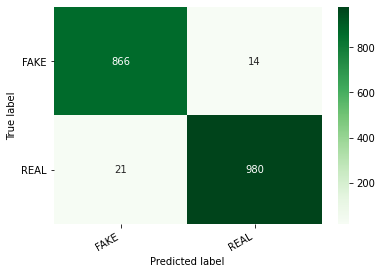

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.xlabel('Predicted label')
    plt.ylabel('True label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['FAKE', 'REAL'], columns=['FAKE', 'REAL'])
show_confusion_matrix(df_cm)

In [22]:
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mc = matthews_corrcoef(y_test, y_pred)
print(f'f1 score       = {f1}\nprecision      = {precision}\nrecall         = {recall}\nmc coefficient = {mc}')

f1 score       = 0.9824561403508772
precision      = 0.9859154929577465
recall         = 0.9790209790209791
mc coefficient = 0.9626759368515396


In [23]:
most_off = np.argmax(np.abs(y_test - y_hat))
actual_binary = y_test[most_off]
actual_label = ['REAL', 'FAKE'][int(actual_binary)]
predicted_label = ['REAL', 'FAKE'][int(y_pred[most_off])]
print(f'Actual label was {actual_binary} ({actual_label}), model said {y_hat[most_off]} ({predicted_label})')
test.iloc[most_off].title, test.iloc[most_off].text

Actual label was [1] (FAKE), model said [4.3210457e-07] (REAL)


("Rush Limbaugh: Left Has 'Fear and Hatred of Christianity'",
 'Pick Your 2016 GOP Candidate -- Let Rush Know! Vote here\n\n')

Code to produce a simple word cloud to evaluate the title embedding versus the text embedding.

In [24]:
def get_reshaped_weights(model,layer_id):
    W = np.array(model.layers[layer_id].get_weights())
    W = W.reshape(W.shape[1], W.shape[2])
    return W
text_embed = get_reshaped_weights(model, 2)
title_embed = get_reshaped_weights(model, 4)

/share/apps/rc/software/Anaconda3/2020.07/envs/deepNLP2020/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/share/apps/rc/software/Anaconda3/2020.07/envs/deepNLP2020/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


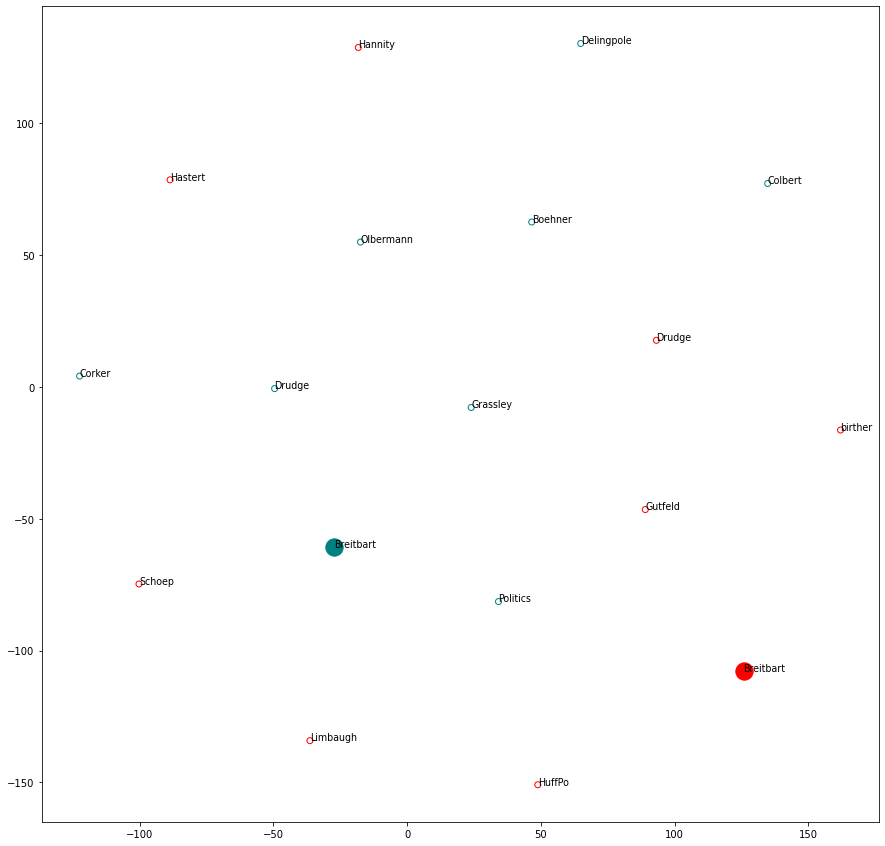

In [25]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k - 1)
    ids2 = get_most_similar(WORD, embed2, k - 1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2, random_state=SEED).fit_transform(
        np.concatenate([embed1[ids1], embed2[ids2]]))
    plt.figure(figsize=(15,15))
    plt.scatter(v[:k, 0], v[:k, 1], facecolors='none', edgecolors='teal')
    plt.scatter(v[k:, 0], v[k:, 1], facecolors='none', edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate(word, (v[i, 0], v[i, 1]), size=9.5)
        if word == WORD:
            plt.scatter(v[i, 0], v[i, 1], c='teal', s=300)
    for i, word in enumerate(words2):
        plt.annotate(word, (v[i + k, 0], v[i + k, 1]), size=9.5)
        if word == WORD:
            plt.scatter(v[i + k, 0], v[i + k, 1], c='red', s=300)
create_words_plot(text_embed, title_embed, 'Breitbart')